In [ ]:
# SET GOOGLE COLABORATORY
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

#lists the content of your google drive
#!ls "/content/drive/My Drive"
!pwd
#!what
!ls "/content/drive/MyDrive/Fruit-Images-Dataset-master/"

Found GPU at: /device:GPU:0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWgA0L-7XZS7hID_E1F4JmmVTB_SyMlSf9diJ0hO0iTFU1J0JhFt2Sk
Mounted at /content/drive
/content
Fruit-Images-Dataset-master


In [ ]:
import os

output_dir = '/content/drive/MyDrive/Fruit-Images-Dataset-master/Fruit-Images-Dataset-master/output_dirResNET'  # root folder in which to save the output files; the files will be under output_files/model_name / dn to dimiourgei to declare

if not os.path.exists(output_dir):      
   print('Output dir created')
   os.makedirs(output_dir) 
else:
  print('Output dir already existed')         
  !ls -ltr '/content/drive/MyDrive/Fruit-Images-Dataset-master/Fruit-Images-Dataset-master/output_dirResNET'

!nvidia-smi

Output dir already existed
total 4
drwx------ 2 root root 4096 Sep  6 15:01 'fruit-360 model'
Sun Sep 26 23:14:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    37W / 250W |    345MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+------------------

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import os
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint


##############################################
learning_rate = 0.1  # initial learning rate
min_learning_rate = 0.00001  # once the learning rate reaches this value, do not decrease it further
learning_rate_reduction_factor = 0.5  # the factor used when reducing the learning rate -> learning_rate *= learning_rate_reduction_factor
patience = 3  # how many epochs to wait before reducing the learning rate when the loss plateaus
verbose = 1  # controls the amount of logging done during training and testing: 0 - none, 1 - reports metrics after each batch, 2 - reports metrics after each epoch
image_size = (100, 100)  # width and height of the used images
input_shape = (100, 100, 3)  # the expected input shape for the trained models; since the images in the Fruit-360 are 100 x 100 RGB images, this is the required input shape

use_label_file = False  # set this to true if you want load the label names from a file; uses the label_file defined below; the file should contain the names of the used labels, each label on a separate line
label_file = 'labels.txt'
base_dir = '/content/drive/MyDrive/Fruit-Images-Dataset-master/Fruit-Images-Dataset-master'
#base_dir = '../..'  # relative path to the Fruit-Images-Dataset folder
test_dir = os.path.join(base_dir, 'Test')
train_dir = os.path.join(base_dir, 'Training')
output_dir = '/content/drive/MyDrive/Fruit-Images-Dataset-master/Fruit-Images-Dataset-master/output_dirResNET'  # root folder in which to save the output files; the files will be under output_files/model_name / dn to dimiourgei to declare
##############################################





labels = os.listdir(train_dir)    
num_classes = len(labels)            


# create 2 charts, one for accuracy, one for loss, to show the evolution of these two metrics during the training process
def plot_model_history(model_history, out_path=""):           
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))            
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'])  
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1), len(model_history.history['accuracy']))  
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))
    axs[1].legend(['train', 'val'], loc='best')
    # save the graph in a file called "acc_loss.png" to be available for later; the model_name is provided when creating and training a model
    if out_path:
        plt.savefig(out_path + "/acc_loss.png")
    plt.show()   


# create a confusion matrix to visually represent incorrectly classified images
def plot_confusion_matrix(y_true, y_pred, classes, out_path=""):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])   # multiclassification Dataframe 
    plt.figure(figsize=(40, 40))
    ax = sn.heatmap(df_cm, annot=True, square=True, fmt="d", linewidths=.2, cbar_kws={"shrink": 0.8})
    if out_path:
        plt.savefig(out_path + "/confusion_matrix.png")  # as in the plot_model_history, the matrix is saved in a file called "model_name_confusion_matrix.png"
    return ax


# Randomly changes hue and saturation of the image to simulate variable lighting conditions

def augment_image(x):
    import tensorflow as tf   
    x = tf.image.random_saturation(x, 0.9, 1.2)
    x = tf.image.random_hue(x, 0.02)
    x =  preprocess_input(x)

    return x
# given the train and test folder paths and a validation to test ratio, this method creates three generators
#  - the training generator uses (100 - validation_percent) of images from the train set 
#    it applies random horizontal and vertical flips for data augmentation and generates batches randomly
#  - the validation generator uses the remaining validation_percent of images from the train set
#    does not generate random batches, as the model is not trained on this data
#    the accuracy and loss are monitored using the validation data so that the learning rate can be updated if the model hits a local optimum
#  - the test generator uses the test set without any form of augmentation
#    once the training process is done, the final values of accuracy and loss are calculated on this set
def build_data_generators(train_folder, test_folder, validation_percent, labels=None, image_size=(100, 100), batch_size=50):   # HOLD-OUT method #
    train_datagen = ImageDataGenerator(     # dn dinw kapoia klisi apla rotate randomly
        preprocessing_function=augment_image,               
        width_shift_range=0.0,
        height_shift_range=0.0,
        zoom_range=0.0,
        horizontal_flip=True,
        vertical_flip=True,  
        validation_split=validation_percent)  # percentage indicating how much of the training set should be kept for validation

    test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input )

# x_gen are tuples of (x, y) where x is a numpy array containing a batch of images with shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels.

    train_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',    
                                                  batch_size=batch_size, shuffle=True, subset='training', classes=labels)
    validation_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                       batch_size=batch_size, shuffle=False, subset='validation', classes=labels)
    test_gen = test_datagen.flow_from_directory(test_folder, target_size=image_size, class_mode='sparse',
                                                batch_size=batch_size, shuffle=False, subset=None, classes=labels)
    return train_gen, validation_gen, test_gen


# this method performs all the steps from data setup, training and testing the model and plotting the results
# the model is any trainable model; the input shape and output number of classes is dependant on the dataset used, in this case the input is 100x100 RGB images and the output is a softmax layer with 118 (LATHOS 131) probabilities
# the name is used to save the classification report containing the f1 score of the model, the plots showing the loss and accuracy and the confusion matrix
# the batch size is used to determine the number of images passed through the network at once, the number of steps per epochs is derived from this as (total number of images in set // batch size) + 1
def train_and_evaluate_model(model, name="", epochs=1, batch_size=50, verbose=verbose, useCkpt=False):
    print(model.summary())
    model_out_dir = os.path.join(output_dir, name)
    if not os.path.exists(model_out_dir):
        os.makedirs(model_out_dir)
    if useCkpt:
        model.load_weights(model_out_dir + "/model.h5")

    trainGen, validationGen, testGen = build_data_generators(train_dir, test_dir, validation_percent=0.1, labels=labels, image_size=image_size, batch_size=batch_size)
    optimizer = Adadelta(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=patience, verbose=verbose, 
                                                factor=learning_rate_reduction_factor, min_lr=min_learning_rate)
    save_model = ModelCheckpoint(filepath=model_out_dir + "/model.h5", monitor='val_accuracy', verbose=verbose,    # create a call back that saves models weights , ta grafei sto idio arxeio model.h5
                                 save_best_only=True, save_weights_only=False, mode='max', period=1)
    
  
    history = model.fit(trainGen,       
                                  epochs=epochs,
                                  steps_per_epoch=(trainGen.n // batch_size) + 1,
                                  validation_data=validationGen,
                                  validation_steps=(validationGen.n // batch_size) + 1,        
                                  verbose=verbose,
                                  callbacks=[learning_rate_reduction, save_model])   # pass callback to training  

    model.load_weights(model_out_dir + "/model.h5")     
    validationGen.reset()                               


    loss_v, accuracy_v = model.evaluate(validationGen, steps=(validationGen.n // batch_size) + 1, verbose=verbose)      # evaluate unseen data (validation % of dataset) #
    loss, accuracy = model.evaluate(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)                      # evaluate test data (from test folder)
    print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
    print("Test: accuracy = %f  ;  loss_v = %f" % (accuracy, loss))
    plot_model_history(history, out_path=model_out_dir)

    print(trainGen)

    testGen.reset()
    
    
    y_pred = model.predict(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
    y_true = testGen.classes[testGen.index_array]
    plot_confusion_matrix(y_true, y_pred.argmax(axis=-1), labels, out_path=model_out_dir)
    class_report = classification_report(y_true, y_pred.argmax(axis=-1), target_names=labels)

    with open(model_out_dir + "/classification_report.txt", "w") as text_file:
        text_file.write("%s" % class_report)
    print(class_report)


print(num_classes)



131


In [ ]:
# Print Summary of ResNet-50 model

from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model

input_shape = ((224, 224, 3))
base_model = ResNet50(include_top = True, weights = 'imagenet', input_shape=input_shape)
print(base_model.summary())


102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
1220/1220 [==============================] - 353s 290ms/step - loss: 0.0081 - accuracy: 0.9981 - val_loss: 0.0143 - val_accuracy: 0.9976

Epoch 00002: val_accuracy did not improve from 0.99822
Epoch 3/10
1220/1220 [==============================] - 351s 288ms/step - loss: 0.0059 - accuracy: 0.9986 - val_loss: 0.0112 - val_accuracy: 0.9979

Epoch 00003: val_accuracy did not improve from 0.99822
Epoch 4/10
1220/1220 [==============================] - 348s 285ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0164 - val_accuracy: 0.9967

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.

Epoch 00004: val_accuracy did not improve from 0.99822
Epoch 5/10
1220/1220 [==============================] - 341s 280ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.0059 - val_accuracy: 0.9988

Epoch 00005: val_accuracy improved from 0.99822 to 0.99881, saving model to /content/drive/MyDrive/Fruit-Images-Dataset-master/Fruit-Images-Dataset-master/outpu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


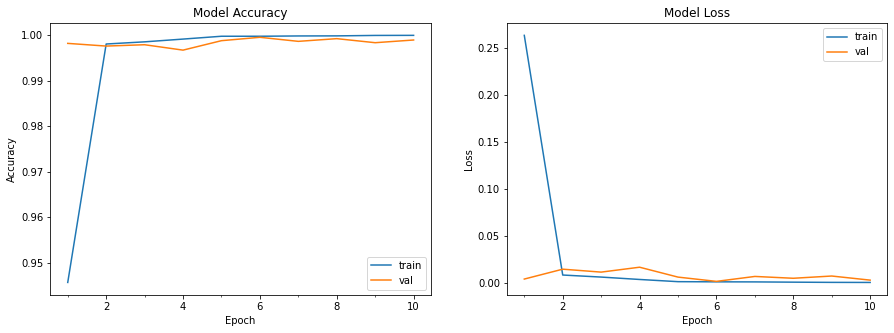

454/454 [==============================] - 43s 93ms/step
                     precision    recall  f1-score   support

     Apple Braeburn       1.00      1.00      1.00       164
 Apple Crimson Snow       1.00      1.00      1.00       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       1.00      1.00      1.00       164
     Apple Golden 3       1.00      1.00      1.00       161
 Apple Granny Smith       1.00      1.00      1.00       164
    Apple Pink Lady       1.00      1.00      1.00       152
        Apple Red 1       1.00      1.00      1.00       164
        Apple Red 2       1.00      1.00      1.00       164
        Apple Red 3       1.00      1.00      1.00       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       1.00      1.00      1.00       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       1.00      1.00      1.00       164
            Avocado       1

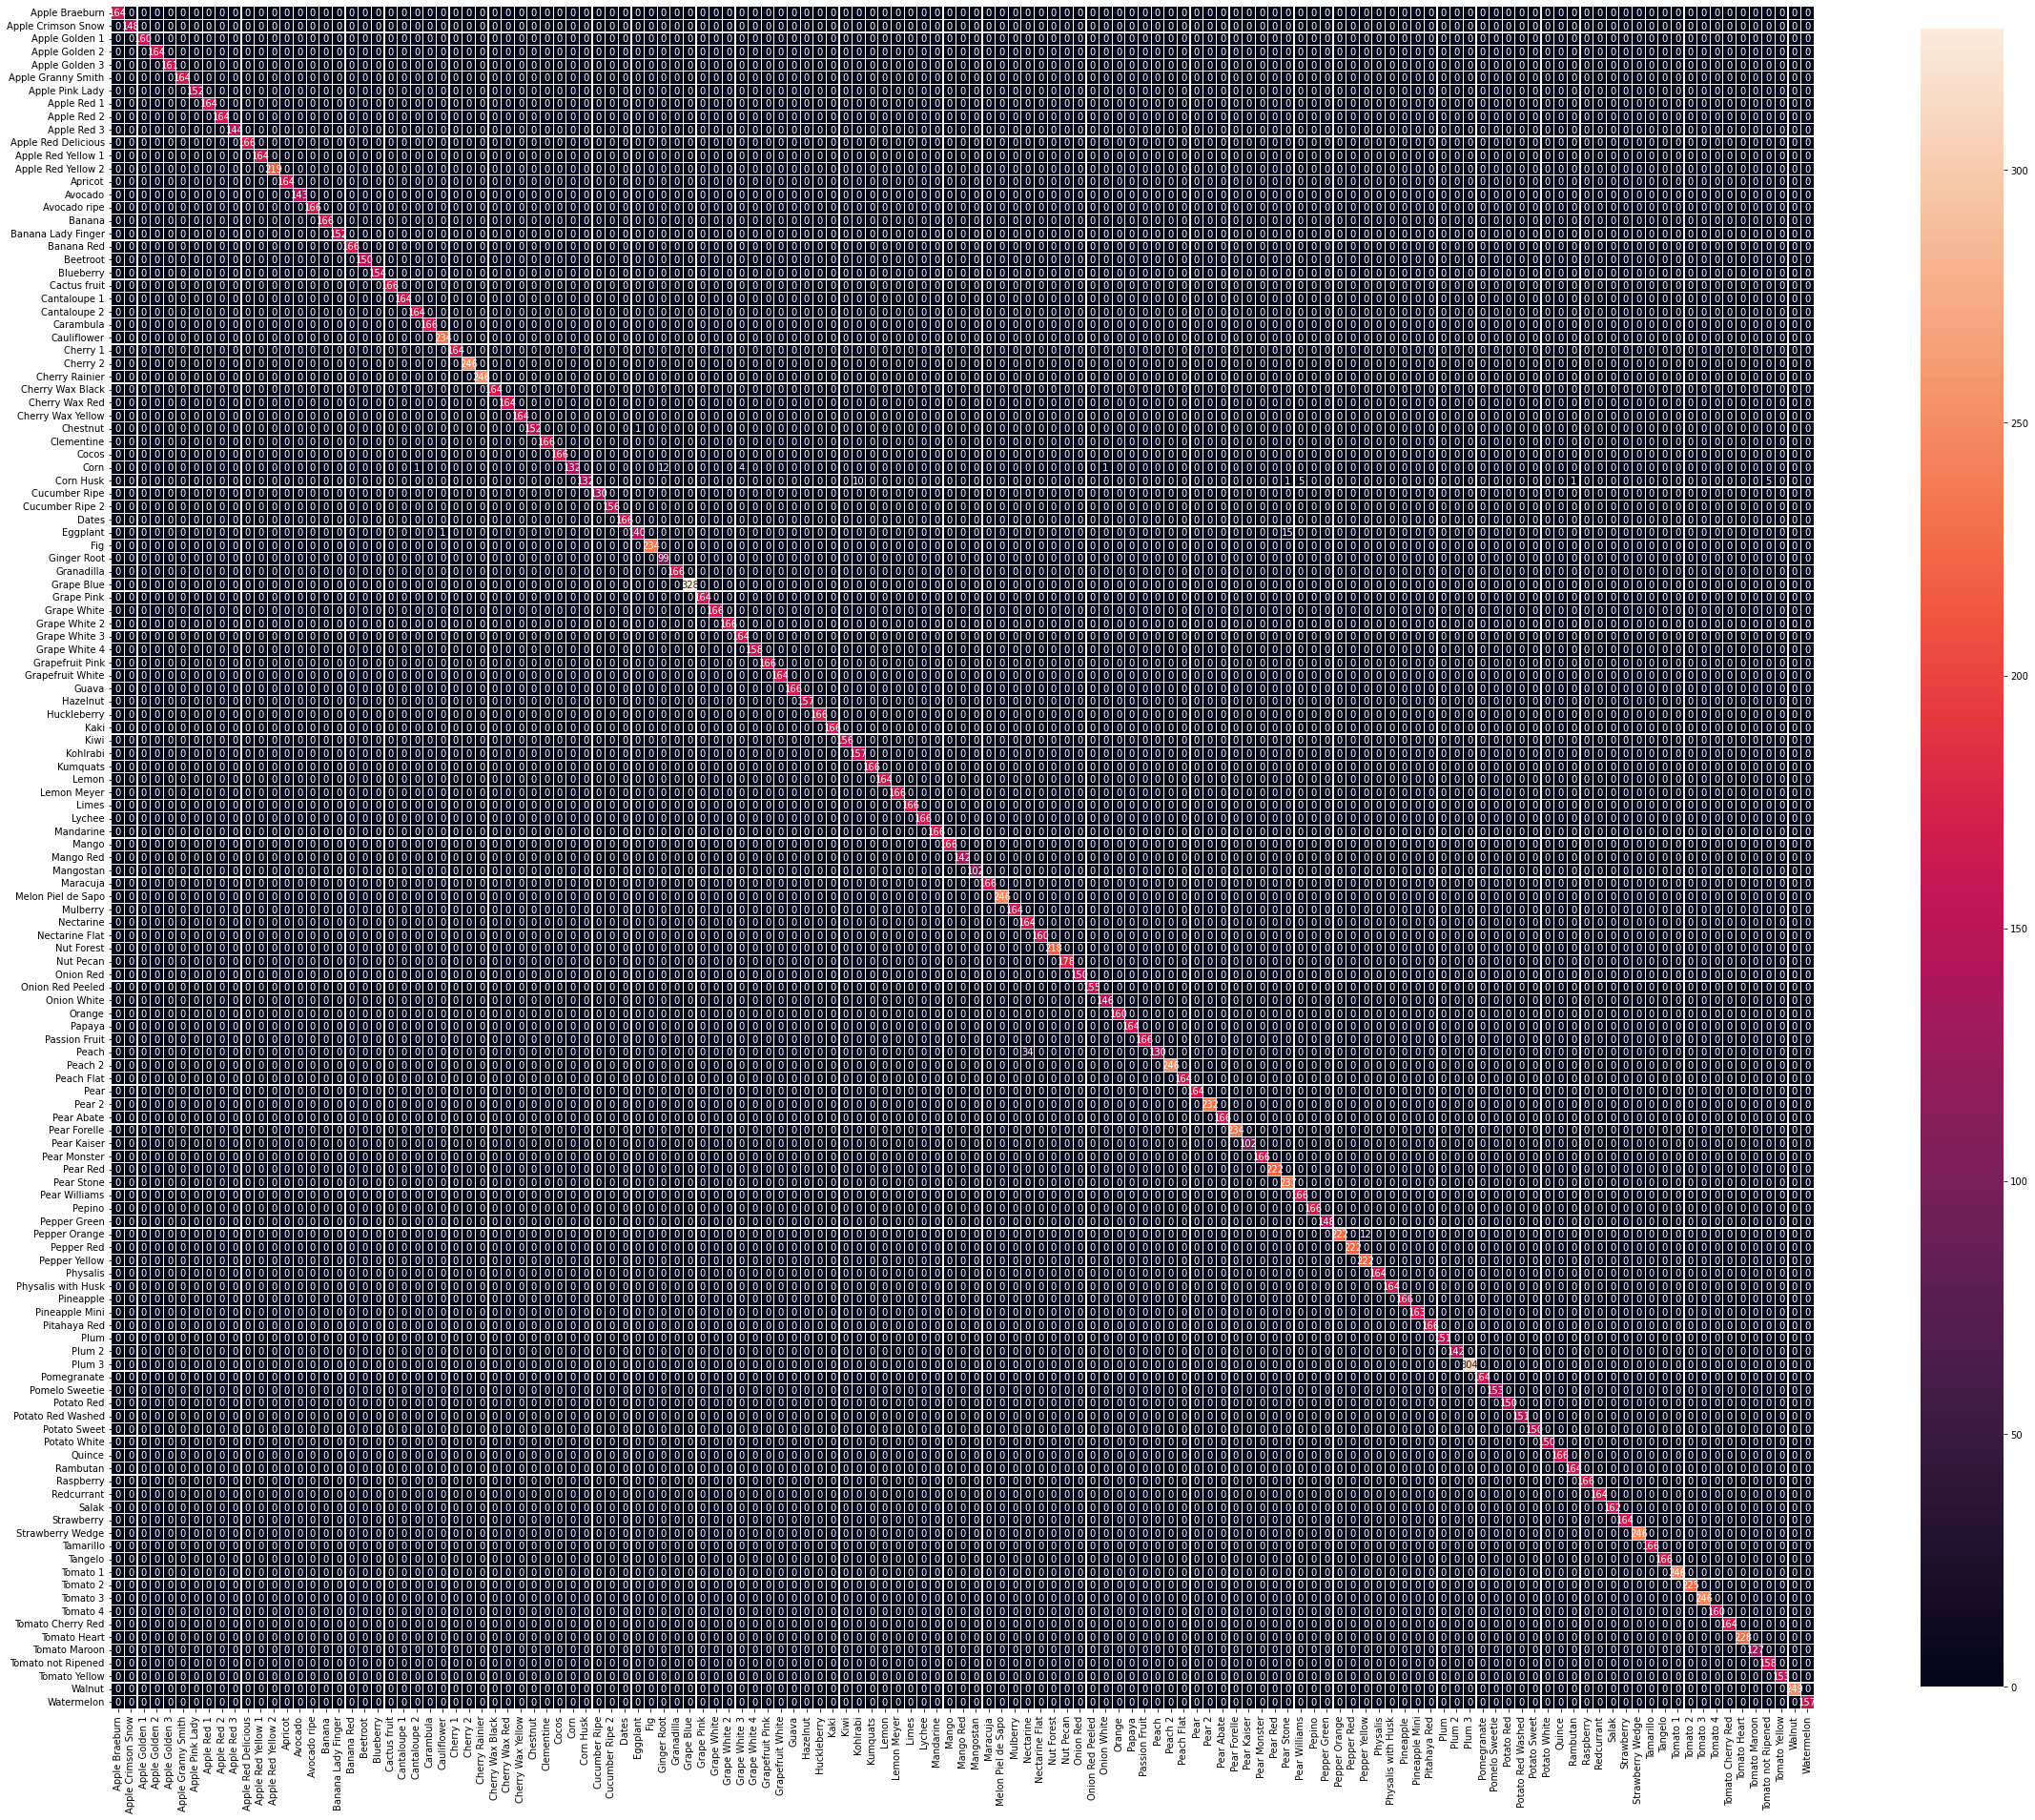

In [ ]:
from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, Lambda
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
#from keras.applications.resnet50 import preprocess_input
from keras.layers import Input, Flatten, Dense,GlobalAveragePooling2D, Dropout
from keras.models import Model

input_shape = (100, 100, 3)
num_classes = len(labels)

# Create a custom layer that converts the original image from
# RGB to HSV and grayscale and concatenates the results
# forming in input of size 100 x 100 x 4
def image_to_rgb(x):
    import tensorflow as tf
    rez = x
    return rez


base_model = ResNet50(include_top = False, weights = 'imagenet', input_shape=input_shape) #import weights gia arxikopoisi kai import only feature extractor, not fully connected layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', name='fcl1')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu', name='fcl2')(x)
x = Dropout(0.2)(x)
predictions = Dense(131, activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=predictions)


train_and_evaluate_model(model, name="fruit-360 model", epochs=10)